# 사용할 패키지

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Conv3D, ConvLSTM2D, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from keras import backend as K

# TPU 장치 설정

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 
    # default distribution strategy in Tensorflow. Works on CPU and single GPU.
print("REPLICAS: ", strategy.num_replicas_in_sync)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
path = '/content/drive/MyDrive/'

# 데이터 가져오기

In [6]:
train_csv = pd.read_csv(path+'train.csv')

In [ ]:
train_csv.head(30)

전체 데이터중 최근 30년 데이터만 학습에 사용하였습니다.

In [8]:
train_path = sorted(glob('/content/drive/MyDrive/train/*.npy'))
train_path = train_path[-31*12:-12]

In [9]:
train = []
for p in tqdm(train_path):
    train.append(np.load(p))
train = np.array(train)

100%|██████████| 360/360 [00:01<00:00, 332.16it/s]


In [10]:
train.shape

(360, 448, 304, 5)

# 데이터 시각화

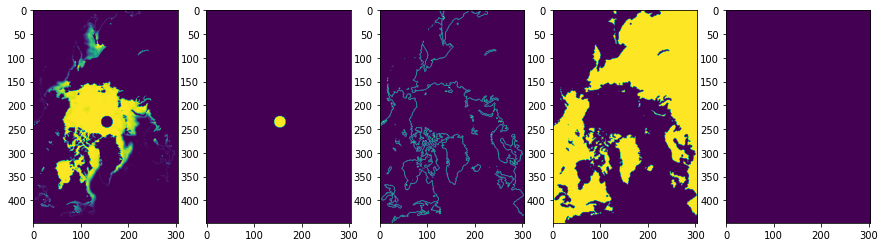

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(151)
plt.imshow(train[0,:,:,0])
plt.subplot(152)
plt.imshow(train[0,:,:,1])
plt.subplot(153)
plt.imshow(train[0,:,:,2])
plt.subplot(154)
plt.imshow(train[0,:,:,3])
plt.subplot(155)
plt.imshow(train[0,:,:,4])

In [ ]:
missings = pd.DataFrame()

for k in range(360) : 
  missings = pd.concat([missings,pd.DataFrame(train[k,:,:,4].reshape(-1,1))],ignore_index=True)

print(missings.min().min())
print(missings.max().max())

0
0


In [11]:
train[0,:,:,0] + train[0,:,:,1]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [12]:
for k in range(360) :

  new_array = train[k,:,:,0] + train[k,:,:,1]*250
  train[k,:,:,0] = new_array

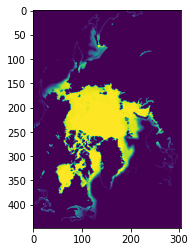

In [ ]:
plt.imshow(train[0,:,:,0])

In [13]:
train.shape

(360, 448, 304, 5)

In [ ]:
pip install uNet

In [12]:
import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate

In [ ]:
inputs = Input(shape=(448,304,1))
s = Lambda(lambda x: x / 250) (inputs)

c1 = Conv2D(filters = 16, kernel_size = (3, 3), activation = 'elu', kernel_initializer='he_normal', padding='same')(s)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2,2))(c1)

c2 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2,2))(c2)

c3 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = BatchNormalization()(c3)
c3 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)

outputs_1 = Conv2D(1, (1,1), activation = 'sigmoid')(c3)

u3 = Conv2DTranspose(filters = 16, kernel_size = (2, 2), strides=(2, 2), padding='same') (c3)
u3 = concatenate([u3, c2], axis=3)
u4 = Conv2DTranspose(filters = 16, kernel_size = (2, 2), strides=(2, 2), padding='same') (u3)
u4 = concatenate([u4, c1], axis=3)
c4 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u4)
c4 = BatchNormalization()(c4)
c4 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)

outputs_2 = Conv2D(1, (1,1), activation = 'sigmoid')(c4)

In [ ]:
model_encode = Model(inputs=[inputs],outputs=[outputs_1])

optimizer = Adam(lr=0.001)
model_encode.compile(optimizer=optimizer, loss = 'mean_squared_error')
model_encode.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 448, 304, 1)]     0         
_________________________________________________________________
lambda (Lambda)              (None, 448, 304, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 448, 304, 16)      160       
_________________________________________________________________
batch_normalization (BatchNo (None, 448, 304, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 224, 152, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 152, 128)     18560     
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 152, 128)     512   

In [ ]:
model_decode = Model(inputs=[inputs], outputs=[outputs_2])

optimizer = Adam(lr=0.001)
model_decode.compile(optimizer=optimizer, loss = 'mean_squared_error')
model_decode.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 448, 304, 1) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 448, 304, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 448, 304, 16) 160         lambda[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 448, 304, 16) 64          conv2d[0][0]                     
____________________________________________________________________________________________

In [ ]:
train[:,:,:,0].shape

(360, 448, 304)

In [ ]:
train_set = train[:,:,:,0].reshape(360,448,304,1)
train_set.shape

(360, 448, 304, 1)

In [ ]:
results = model_decode.fit(train_set,train_set,batch_size=10,epochs=10)

Epoch 1/10
36/36 [==============================] - 57s 2s/step - loss: 6161.5280
Epoch 2/10
36/36 [==============================] - 56s 2s/step - loss: 6055.6484
Epoch 3/10
36/36 [==============================] - 56s 2s/step - loss: 6124.1890
Epoch 4/10
36/36 [==============================] - 56s 2s/step - loss: 6105.8235
Epoch 5/10
36/36 [==============================] - 56s 2s/step - loss: 5911.5943
Epoch 6/10
36/36 [==============================] - 56s 2s/step - loss: 6159.0395
Epoch 7/10
36/36 [==============================] - 56s 2s/step - loss: 6085.3640
Epoch 8/10
36/36 [==============================] - 56s 2s/step - loss: 6009.4566
Epoch 9/10
36/36 [==============================] - 56s 2s/step - loss: 6008.3789
Epoch 10/10
36/36 [==============================] - 56s 2s/step - loss: 6171.9471


In [ ]:
predict_set_unet = model_encode.predict(train_set)

In [ ]:
predict_set_unet.shape

(360, 112, 76, 1)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54617 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49845 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44208 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44284 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_

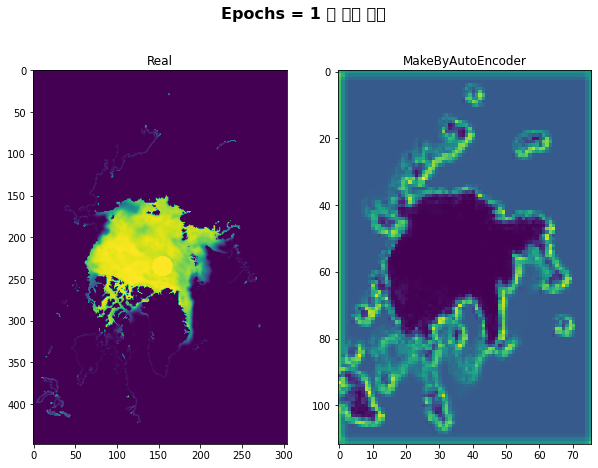

In [ ]:
import matplotlib.pyplot as plt 
%matplotlib inline 

from matplotlib import rc
rc('font', family='NanumMyeongjo')
plt.rcParams['axes.unicode_minus'] = False

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,10))

img1 = train_set[45].reshape(448,304)
img2 = predict_set_unet[45].reshape(112,76)

ax1.imshow(img1)
ax1.set_title("Real")
ax2.imshow(img2)
ax2.set_title("MakeByAutoEncoder")
st = fig.suptitle('Epochs = 1 의 학습 결과', fontsize = 16, fontweight = 'bold')
st.set_y(0.85)
plt.show()

In [ ]:
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose,Reshape
from keras.layers import Activation, LeakyReLU, Dropout, BatchNormalization, MaxPooling3D, UpSampling2D, UpSampling3D, Conv3DTranspose
from keras.models import Model
from keras import backend as K 
from keras.optimizers import Adam

In [ ]:
encoder_input = Input(shape = (448, 304, 1))

x = Conv2D(filters = 4, kernel_size = 3, strides = 1, padding = "same")(encoder_input)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
shape_before_flatten = K.int_shape(x)[1:]

x = Flatten()(x)
encoder_output = Dense(units = 2)(x)

model_encoder = Model(encoder_input, encoder_output)
model_encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 448, 304, 1)]     0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 448, 304, 4)       40        
_________________________________________________________________
batch_normalization_5 (Batch (None, 448, 304, 4)       16        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 448, 304, 4)       0         
_________________________________________________________________
flatten (Flatten)            (None, 544768)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1089538   
Total params: 1,089,594
Trainable params: 1,089,586
Non-trainable params: 8
_________________________________________________

In [ ]:
decoder_input = Input(shape = (2,)) # encoder output shape

x = Dense(units = np.prod(shape_before_flatten))(decoder_input)
x = Reshape(shape_before_flatten)(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(filters = 1, kernel_size = 3, strides = 1, padding ='same')(x)
#x = MaxPooling2D((3,3))(x)
x = Activation('sigmoid')(x)

decoder_output = x 

model_decoder = Model(decoder_input, decoder_output)
model_decoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 544768)            1634304   
_________________________________________________________________
reshape_1 (Reshape)          (None, 448, 304, 4)       0         
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 448, 304, 4)       0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 448, 304, 4)       16        
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 448, 304, 1)       37        
_________________________________________________________________
activation_1 (Activation)    (None, 448, 304, 1)       0   

In [ ]:
model_input = encoder_input
model_output = model_decoder(encoder_output)

AutoEncoder = Model(model_input, model_output)
AutoEncoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 448, 304, 1)]     0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 448, 304, 4)       40        
_________________________________________________________________
batch_normalization_5 (Batch (None, 448, 304, 4)       16        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 448, 304, 4)       0         
_________________________________________________________________
flatten (Flatten)            (None, 544768)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1089538   
_________________________________________________________________
model_4 (Functional)         (None, 448, 304, 1)       1634

In [ ]:
optimizer = Adam(lr = 0.001) # 학습률 
AutoEncoder.compile(optimizer = optimizer,
                   loss = 'mean_squared_error')

In [ ]:
train_set_half = MaxPooling2D((3,3))(train_set)
train_set_half.shape

TensorShape([360, 149, 101, 1])

In [ ]:
AutoEncoder.fit(train_set, # data
                train_set, # target data 
               batch_size = 10, shuffle =True, epochs = 10)

Epoch 1/10
36/36 [==============================] - 7s 173ms/step - loss: 6022.4014
Epoch 2/10
36/36 [==============================] - 6s 173ms/step - loss: 6022.3306
Epoch 3/10
36/36 [==============================] - 6s 172ms/step - loss: 6022.2939
Epoch 4/10
36/36 [==============================] - 6s 174ms/step - loss: 6022.2729
Epoch 5/10
36/36 [==============================] - 6s 173ms/step - loss: 6022.2583
Epoch 6/10
36/36 [==============================] - 6s 172ms/step - loss: 6022.2480
Epoch 7/10
36/36 [==============================] - 6s 173ms/step - loss: 6022.2417
Epoch 8/10
36/36 [==============================] - 6s 175ms/step - loss: 6022.2383
Epoch 9/10
36/36 [==============================] - 6s 174ms/step - loss: 6022.2363
Epoch 10/10
36/36 [==============================] - 6s 174ms/step - loss: 6022.2339


In [ ]:
predict_set_encode = model_encoder.predict(train_set)
predict_set_encode.shape

(360, 2)

# 월별 데이터로 분리

In [14]:
train_month = []
for i in range(12):
    train_month.append(train[i::12, :])
train_month = np.array(train_month)

In [15]:
train_month.shape

(12, 30, 448, 304, 5)

# 이미지를 잘랐을 때 사이즈가 같도록 패딩

In [ ]:
stride = 32
temp = np.zeros([train_month.shape[0],
                 train_month.shape[1],
                 train_month.shape[2]+(stride-train_month.shape[2]%stride),
                 train_month.shape[3]+(stride-train_month.shape[3]%stride),
                 train_month.shape[4]], np.uint8)
temp[:, :,:train_month.shape[2], :train_month.shape[3], :] = train_month
train_month = temp
del temp

In [ ]:
train_month.shape

(12, 30, 480, 320, 5)

# 5년 단위로 데이터 전처리

In [133]:
window_size = 10

In [134]:
x_train = []
y_train = []

for i in range(train_month.shape[1]-window_size):
    x_train.append(train_month[:, i:i+window_size, :])
    y_train.append(train_month[:, i+window_size:i+window_size+1, :])
    
x_train = np.array(x_train)
y_train = np.array(y_train)

In [135]:
x_train.shape, y_train.shape

((20, 12, 10, 448, 304, 5), (20, 12, 1, 448, 304, 5))

# 시각화

특정 월의 5년간 변화와 그 다음 상태

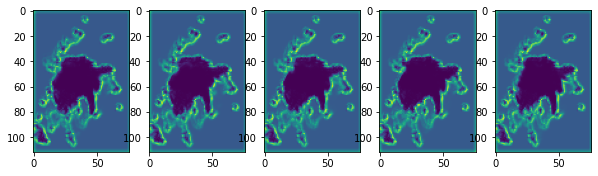

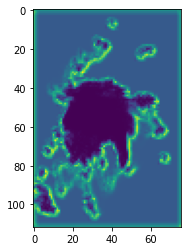

In [ ]:
m = 10
plt.figure(figsize=(10,15))
for y in range(x_train.shape[2]):
    plt.subplot(1,window_size,y+1)
    plt.imshow(x_train[0,m-1,y,:,:,0])
plt.show()

plt.imshow(y_train[0,m-1,-1,:,:,0])

# 데이터 자르기

이미지가 클 경우 ConvLSTM모델의 메모리가 부족하여 가로세로 32px씩 이동하며 128x128로 이미지를 잘랐습니다.

학습에는 2018년까지, 2018년도를 평가 데이터로 활용하여 학습 결과를 2018년(가장 최근년도)에 과적합시켰습니다.

In [136]:
#stride = 32
#feature_size = 128

x_train_ = []
y_train_ = []

for y in range(15):
    for m in range(12):
      x_ = x_train[y, m, :, :, :,:1]  
      y_ = y_train[y, m, :, :, :,:1] 
      x_train_.append(x_)
      y_train_.append(y_)

x_train_ = np.array(x_train_)
y_train_ = np.array(y_train_)

x_val_ = []
y_val_ = []

for y in range(15,19):
  for m in range(12):
    x_ = x_train[y, m, :, :, :,:1]
    y_ = y_train[y, m, :, :, :,:1]
    x_val_.append(x_)
    y_val_.append(y_)

x_val_ = np.array(x_val_)
y_val_ = np.array(y_val_)

x_test_ = []
y_test_ = []

for y in range(19,20):
  for m in range(12):
    x_ = x_train[y, m, :, :, :,:1]
    y_ = y_train[y, m, :, :, :,:1]
    x_test_.append(x_)
    y_test_.append(y_)

x_test_ = np.array(x_test_)
y_test_ = np.array(y_test_)

In [26]:
#stride = 32
#feature_size = 128

x_train_ = []
y_train_ = []

for y in range(20):
    for m in range(12):
      for k in range(1):
        x_ = x_train[y, m, :, :,:,:1]  
        y_ = y_train[y, m, k, :,:,:1] 
        x_train_.append(x_)
        y_train_.append(y_)

x_train_ = np.array(x_train_)
y_train_ = np.array(y_train_)

x_val_ = []
y_val_ = []

for y in range(20,24):
  for m in range(12):
      for k in range(1):
        x_ = x_train[y, m, :, :,:,:1]
        y_ = y_train[y, m, k, :,:,:1]
        x_val_.append(x_)
        y_val_.append(y_)

x_val_ = np.array(x_val_)
y_val_ = np.array(y_val_)

x_test_ = []
y_test_ = []

for y in range(24,25):
  for m in range(12):
    for k in range(1):
      x_ = x_train[y, m, :, :,:,:1]
      y_ = y_train[y, m, k, :,:,:1]
      x_test_.append(x_)
      y_test_.append(y_)

x_test_ = np.array(x_test_)
y_test_ = np.array(y_test_)

In [137]:
x_train_.shape, y_train_.shape, x_val_.shape, y_val_.shape, x_test_.shape, y_test_.shape

((180, 10, 448, 304, 1),
 (180, 1, 448, 304, 1),
 (48, 10, 448, 304, 1),
 (48, 1, 448, 304, 1),
 (12, 10, 448, 304, 1),
 (12, 1, 448, 304, 1))

# 데이터 시각화

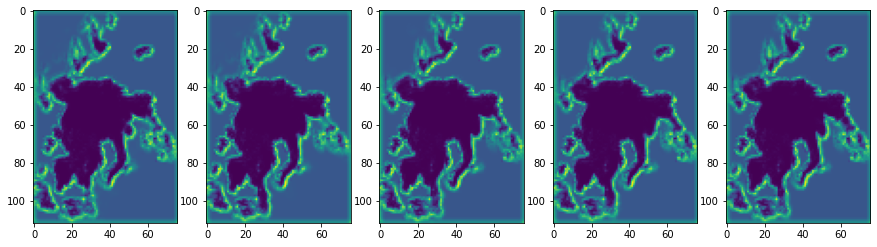

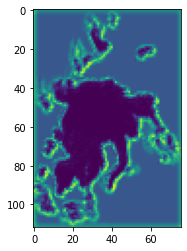

In [ ]:
i = 208
plt.figure(figsize=(15,10))
for y in range(x_train_.shape[1]):
    plt.subplot(1,window_size,y+1)
    plt.imshow(x_train_[i,y,:,:,0])
plt.show()
plt.imshow(y_train_[i,-1,:,:,0])

# 데이터셋

In [ ]:
def train_map_func(x, y):
    x = tf.cast(x, tf.float32)/250
    y = tf.cast(y, tf.float32)
    return x, y

In [ ]:
BATCH_SIZE = 1

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_, y_train_))
train_dataset = train_dataset.map(train_map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val_, y_val_))
val_dataset = val_dataset.map(train_map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test_, y_test_))
test_dataset = test_dataset.map(train_map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
next(iter(train_dataset))[0].shape, next(iter(train_dataset))[1].shape

(TensorShape([1, 5, 112, 76, 1]), TensorShape([1, 1, 112, 76, 1]))

In [ ]:
next(iter(val_dataset))[0].shape, next(iter(val_dataset))[1].shape

(TensorShape([1, 5, 112, 76, 1]), TensorShape([1, 1, 112, 76, 1]))

In [ ]:
np.array(train_dataset)

array(<ParallelMapDataset shapes: ((5, 128, 128, 1), (1, 128, 128, 1)), types: (tf.float32, tf.float32)>,
      dtype=object)

# 모델

keras를 이용해 간단한 ConvLSTM 모델을 만들었습니다.

메모리가 많이 필요하여 colab TPU 사용을 권장드립니다.

In [21]:
from tensorflow import keras

In [ ]:
[name for name in dir(keras.layers) if not name.startswith("_")]

['AbstractRNNCell',
 'Activation',
 'ActivityRegularization',
 'Add',
 'AdditiveAttention',
 'AlphaDropout',
 'Attention',
 'Average',
 'AveragePooling1D',
 'AveragePooling2D',
 'AveragePooling3D',
 'AvgPool1D',
 'AvgPool2D',
 'AvgPool3D',
 'BatchNormalization',
 'Bidirectional',
 'Concatenate',
 'Conv1D',
 'Conv1DTranspose',
 'Conv2D',
 'Conv2DTranspose',
 'Conv3D',
 'Conv3DTranspose',
 'ConvLSTM2D',
 'Convolution1D',
 'Convolution1DTranspose',
 'Convolution2D',
 'Convolution2DTranspose',
 'Convolution3D',
 'Convolution3DTranspose',
 'Cropping1D',
 'Cropping2D',
 'Cropping3D',
 'Dense',
 'DenseFeatures',
 'DepthwiseConv2D',
 'Dot',
 'Dropout',
 'ELU',
 'Embedding',
 'Flatten',
 'GRU',
 'GRUCell',
 'GaussianDropout',
 'GaussianNoise',
 'GlobalAveragePooling1D',
 'GlobalAveragePooling2D',
 'GlobalAveragePooling3D',
 'GlobalAvgPool1D',
 'GlobalAvgPool2D',
 'GlobalAvgPool3D',
 'GlobalMaxPool1D',
 'GlobalMaxPool2D',
 'GlobalMaxPool3D',
 'GlobalMaxPooling1D',
 'GlobalMaxPooling2D',
 'Global

In [ ]:
#unet

with strategy.scope():
    inputs=Input((None, x_train_.shape[2], x_train_.shape[3], 1))



    x3 = MaxPool2D(2)(acti6)
    
    conv7 = Conv2D(512, 3, padding='same')(x3)
    batch7 = BatchNormalization()(conv7)
    acti7 = Activation('relu')(batch7)
    
    conv8 = Conv2D(512, 3, padding='same')(acti7)
    batch8 = BatchNormalization()(conv8)
    acti8 = Activation('relu')(batch8)

    x4 = MaxPool2D(2)(acti8)

    conv9 = Conv2D(1024, 3, padding='same')(x4)
    batch9 = BatchNormalization()(conv9)
    acti9 = Activation('relu')(batch9)
    
    conv10 = Conv2D(1024, 3, padding='same')(acti9)
    batch10 = BatchNormalization()(conv10)
    acti10 = Activation('relu')(batch10)   

    


    model = Model(inputs, outputs)
    model.compile(loss='mae', optimizer=Adam())
    
model.summary()

In [ ]:
#Unet학습

with strategy.scope():
    inputs=Input((None, x_train_.shape[2], x_train_.shape[3], 1))

    

    model = Model(inputs, outputs)
    model.compile(loss='mae', optimizer=Adam())
    
model.summary()

In [39]:
with strategy.scope():
    inputs=Input((None, x_train_.shape[2], x_train_.shape[3], 1))

    x = Conv2D(filters=32,kernel_size=(3,3),padding='same')(inputs)
    x = BatchNormalization()(x)
#    x = Activation('relu')(x)
    x = MaxPooling3D(2)(x)

    x = Conv2D(filters=64,kernel_size=(3,3),padding='same')(x)
    x = BatchNormalization()(x)
#    x = Activation('relu')(x)
    x = MaxPooling3D(2)(x)

    convLSTM = ConvLSTM2D(filters=64, kernel_size=3, padding='same', return_sequences=True)(x)
    convLSTM = BatchNormalization()(convLSTM)

    convLSTM = ConvLSTM2D(filters=64, kernel_size=3, padding='same', return_sequences=True)(convLSTM)
    convLSTM = BatchNormalization()(convLSTM)

    convLSTM = ConvLSTM2D(filters=64, kernel_size=3, padding='same', return_sequences=True)(convLSTM)
    convLSTM = BatchNormalization()(convLSTM)

    x = UpSampling3D(2)(convLSTM)
    x = Conv3DTranspose(64,3,padding='same')(x)

    x = UpSampling3D(2)(x)
    x = Conv3DTranspose(32,3,padding='same')(x)

    outputs = Conv3D(filters=1, kernel_size=3, activation='relu', padding='same', data_format='channels_last')(x)

    model = Model(inputs, outputs)
    model.compile(loss='mae', optimizer=Adam())
    
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None, 448, 304, 1 0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, None, 448, 304, 32 320       
_________________________________________________________________
batch_normalization_15 (Batc (None, None, 448, 304, 32 128       
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, None, 224, 152, 32 0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, None, 224, 152, 64 18496     
_________________________________________________________________
batch_normalization_16 (Batc (None, None, 224, 152, 64 256       
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, None, 112, 76, 64) 0   

In [129]:
with strategy.scope():
    inputs = Input(shape = (x_train_.shape[2], x_train_.shape[3], 1))

    x = Conv2D(filters = 4, kernel_size = 3, strides = 1, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)
    x = Dense(units = 2)(x)

#    x = Conv2D(filters=64,kernel_size=(3,3),padding='same')(x)
#    x = BatchNormalization()(x)
#    x = Activation('relu')(x)
#    x = MaxPooling3D(2)(x)

#    x = Conv2D(filters=64,kernel_size=(3,3),padding='same')(x)
#    x = BatchNormalization()(x)
#    x = Activation('relu')(x)
#    x = MaxPooling3D(2)(x)

    convLSTM = LSTM(5, return_sequences=True)(x)
    convLSTM = BatchNormalization()(convLSTM)

    convLSTM = LSTM(5, return_sequences=True)(convLSTM)
    convLSTM = BatchNormalization()(convLSTM)

    convLSTM = LSTM(5, return_sequences=False)(convLSTM)
    convLSTM = BatchNormalization()(convLSTM)

    x = Dense(units = np.prod(448,304,4))(convLSTM)
    x = Reshape((448,304,4))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(filters = 1, kernel_size = 3, strides = 1, padding ='same')(x)

    outputs = Activation('sigmoid')(x)

#    x = UpSampling3D(2)(convLSTM)
#    x = Conv3DTranspose(64,3,padding='same')(x)

#    x = UpSampling3D(2)(x)
#    x = Conv3DTranspose(32,3,padding='same')(x)

#    outputs = Conv3D(filters=1, kernel_size=3, activation='relu', padding='same', data_format='channels_last')(x)

    model = Model(inputs, outputs)
    model.compile(loss='mae', optimizer=Adam())
    
model.summary()

ValueError: ignored

In [130]:
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose,Reshape
from keras.layers import Activation, LeakyReLU, Dropout, BatchNormalization, MaxPooling3D, UpSampling2D, UpSampling3D, Conv3DTranspose, concatenate, LSTM
from keras.models import Model
from keras import backend as K 
from keras.optimizers import Adam

In [138]:
with strategy.scope():
    inputs=Input((None, x_train_.shape[2], x_train_.shape[3], 1))

#    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
#    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling3D(2)(inputs)

    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
#    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling3D(2)(conv2)

    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
#    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool3 = MaxPooling3D(2)(conv3)

#    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
#    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)


    convLSTM = ConvLSTM2D(filters=64, kernel_size=3, padding='same', return_sequences=True)(pool3)
    convLSTM = BatchNormalization()(convLSTM)

#    convLSTM = ConvLSTM2D(filters=64, kernel_size=3, padding='same', return_sequences=True)(convLSTM)
#    convLSTM = BatchNormalization()(convLSTM)

    convLSTM = ConvLSTM2D(filters=64, kernel_size=3, padding='same', return_sequences=True)(convLSTM)
    convLSTM = BatchNormalization()(convLSTM)


    up7 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(2)(convLSTM))
    merge7 = concatenate([conv3,up7],axis = 1)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
#    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(2)(conv7))
#    merge7 = concatenate([conv2,up7], axis = 1)
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up8)
#    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(2)(conv8))
#    merge8 = concatenate([inputs,up8], axis = 1)
    outputs = Conv2D(1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up8)
#    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

#    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

#    outputs = Conv2D(filters=1, kernel_size=3, activation='relu', padding='same', data_format='channels_last')(conv8)

    model = Model(inputs, outputs)
    model.compile(loss='mae', optimizer=Adam())
    
model.summary()

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_53 (InputLayer)           [(None, None, 448, 3 0                                            
__________________________________________________________________________________________________
max_pooling3d_73 (MaxPooling3D) (None, None, 224, 15 0           input_53[0][0]                   
__________________________________________________________________________________________________
conv2d_196 (Conv2D)             (None, None, 224, 15 320         max_pooling3d_73[0][0]           
__________________________________________________________________________________________________
max_pooling3d_74 (MaxPooling3D) (None, None, 112, 76 0           conv2d_196[0][0]                 
___________________________________________________________________________________________

# 학습

20epochs까지만 학습하였습니다.

In [139]:
x_train_.shape

(180, 10, 448, 304, 1)

In [140]:
if not (os.path.isdir('models')):
    os.makedirs('models')

callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath = './models/convlstm_model.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

hist = model.fit(x_train_,y_train_, epochs=10, validation_data=(x_val_,y_val_), callbacks=callbacks_list)

Epoch 1/10


ResourceExhaustedError: ignored

# 학습 결과

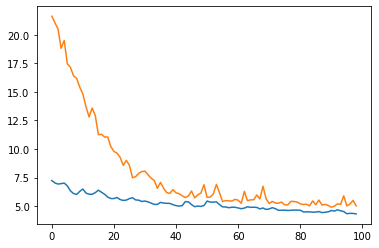

In [43]:
plt.plot(hist.history['loss'][1:])
plt.plot(hist.history['val_loss'][1:])
plt.show()

In [ ]:
import os
import math
import numpy as np
import datetime as dt
from numpy import newaxis
from core.utils import Timer
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

class Model():
	"""A class for an building and inferencing an lstm model"""

	def __init__(self):
		self.model = Sequential()

	def load_model(self, filepath):
		print('[Model] Loading model from file %s' % filepath)
		self.model = load_model(filepath)

	def build_model(self, configs):
		timer = Timer()
		timer.start()

		for layer in configs['model']['layers']:
			neurons = layer['neurons'] if 'neurons' in layer else None
			dropout_rate = layer['rate'] if 'rate' in layer else None
			activation = layer['activation'] if 'activation' in layer else None
			return_seq = layer['return_seq'] if 'return_seq' in layer else None
			input_timesteps = layer['input_timesteps'] if 'input_timesteps' in layer else None
			input_dim = layer['input_dim'] if 'input_dim' in layer else None

			if layer['type'] == 'dense':
				self.model.add(Dense(neurons, activation=activation))
			if layer['type'] == 'lstm':
				self.model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences=return_seq))
			if layer['type'] == 'dropout':
				self.model.add(Dropout(dropout_rate))

		self.model.compile(loss=configs['model']['loss'], optimizer=configs['model']['optimizer'])

		print('[Model] Model Compiled')
		timer.stop()

	def train(self, x, y, epochs, batch_size, save_dir):
		timer = Timer()
		timer.start()
		print('[Model] Training Started')
		print('[Model] %s epochs, %s batch size' % (epochs, batch_size))
		
		save_fname = os.path.join(save_dir, '%s-e%s.h5' % (dt.datetime.now().strftime('%d%m%Y-%H%M%S'), str(epochs)))
		callbacks = [
			EarlyStopping(monitor='val_loss', patience=2),
			ModelCheckpoint(filepath=save_fname, monitor='val_loss', save_best_only=True)
		]
		self.model.fit(
			x,
			y,
			epochs=epochs,
			batch_size=batch_size,
			callbacks=callbacks
		)
		self.model.save(save_fname)

		print('[Model] Training Completed. Model saved as %s' % save_fname)
		timer.stop()

	def train_generator(self, data_gen, epochs, batch_size, steps_per_epoch, save_dir):
		timer = Timer()
		timer.start()
		print('[Model] Training Started')
		print('[Model] %s epochs, %s batch size, %s batches per epoch' % (epochs, batch_size, steps_per_epoch))
		
		save_fname = os.path.join(save_dir, '%s-e%s.h5' % (dt.datetime.now().strftime('%d%m%Y-%H%M%S'), str(epochs)))
		callbacks = [
			ModelCheckpoint(filepath=save_fname, monitor='loss', save_best_only=True)
		]
		self.model.fit_generator(
			data_gen,
			steps_per_epoch=steps_per_epoch,
			epochs=epochs,
			callbacks=callbacks,
			workers=1
		)
		
		print('[Model] Training Completed. Model saved as %s' % save_fname)
		timer.stop()

	def predict_point_by_point(self, data):
		#Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
		print('[Model] Predicting Point-by-Point...')
		predicted = self.model.predict(data)
		predicted = np.reshape(predicted, (predicted.size,))
		return predicted

	def predict_sequences_multiple(self, data, window_size, prediction_len):
		#Predict sequence of 50 steps before shifting prediction run forward by 50 steps
		print('[Model] Predicting Sequences Multiple...')
		prediction_seqs = []
		for i in range(int(len(data)/prediction_len)):
			curr_frame = data[i*prediction_len]
			predicted = []
			for j in range(prediction_len):
				predicted.append(self.model.predict(curr_frame[newaxis,:,:])[0,0])
				curr_frame = curr_frame[1:]
				curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
			prediction_seqs.append(predicted)
		return prediction_seqs

	def predict_sequence_full(self, data, window_size):
		#Shift the window by 1 new prediction each time, re-run predictions on new window
		print('[Model] Predicting Sequences Full...')
		curr_frame = data[0]
		predicted = []
		for i in range(len(data)):
			predicted.append(self.model.predict(curr_frame[newaxis,:,:])[0,0])
			curr_frame = curr_frame[1:]
			curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
		return predicted

# 모델 불러오기

In [44]:
model = load_model('/content/models/convlstm_model.h5')

# 검증셋 추론

In [49]:
pred = model.predict(x_val_)
pred = np.where(pred>250, 250, pred)

In [50]:
pred.shape

(48, 4, 448, 304, 1)

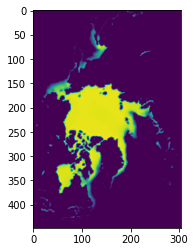

In [ ]:
plt.imshow(pred[0,0,:,:,0])

## 검증셋 추론 결과

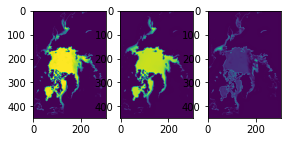

9.262376


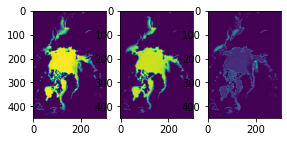

10.099688


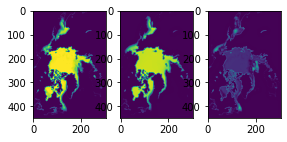

10.028372


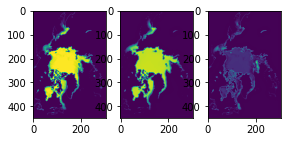

9.358272


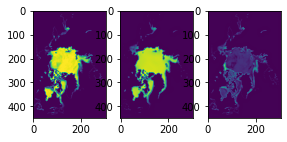

8.703627


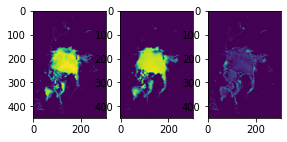

7.2710824


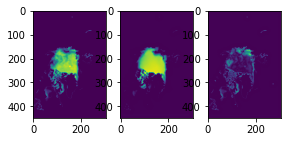

5.5358057


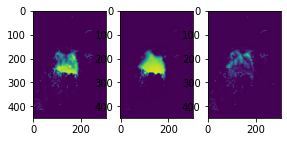

5.037858


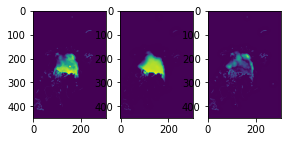

4.908767


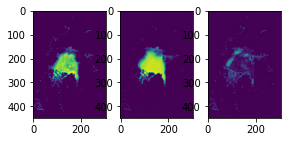

4.6056876


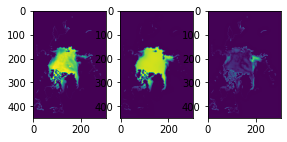

6.2415853


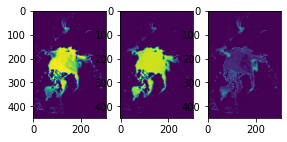

8.411605


In [51]:
for i in range(36,48):
  plt.subplot(141)
  plt.imshow(y_val_[i,0,:,:,0])
  plt.subplot(142)
  plt.imshow(pred[i,0,:,:,0])
  plt.subplot(143)
  plt.imshow(np.abs(y_val_[i,0,:,:,0] - pred[i,0,:,:,0]))
  plt.show()
  print(np.mean(np.abs(y_val_[i,0,:,:,0] - pred[i,0,:,:,0])))
    

In [45]:
pred = model.predict(x_test_)
pred = np.where(pred>250, 250, pred)

In [47]:
pred.shape

(12, 4, 448, 304, 1)

In [48]:
y_test_.shape

(12, 1, 448, 304, 1)

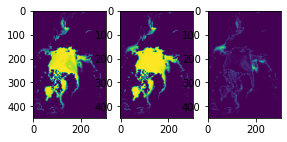

5.6095066


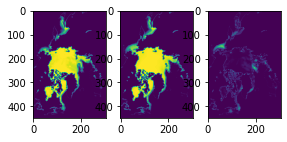

5.140663


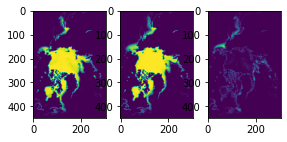

5.4376054


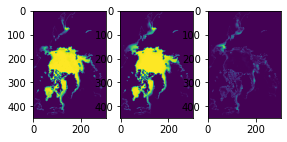

5.0832586


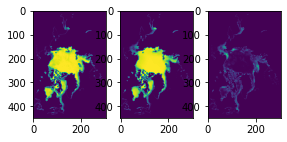

5.0362


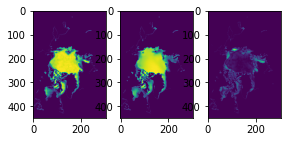

4.982415


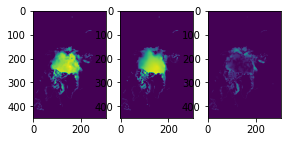

3.9116683


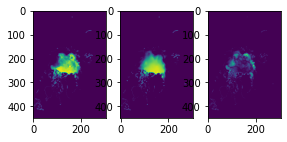

3.567867


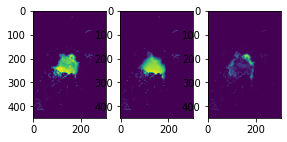

3.454547


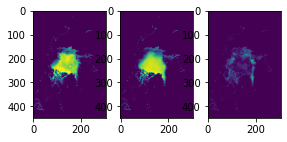

3.9953191


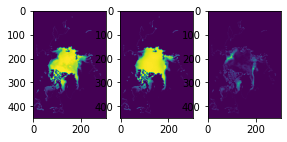

4.3457036


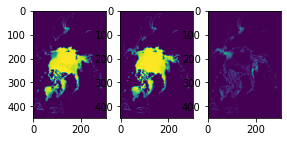

4.500944


In [50]:
for i in range(12):
  plt.subplot(141)
  plt.imshow(y_test_[i,0,:,:,0])
  plt.subplot(142)
  plt.imshow(pred[i,3,:,:,0])
  plt.subplot(143)
  plt.imshow(np.abs(y_test_[i,0,:,:,0] - pred[i,3,:,:,0]))
  plt.show()
  print(np.mean(np.abs(y_test_[i,0,:,:,0] - pred[i,3,:,:,0])))


# 2019년 추론 데이터 전처리

2014 ~ 2018년까지 5년간 월별 데이터를 학습과 같은 형태로 전처리

In [ ]:
x_test = train_month[:,-1*window_size:,:,:,:1]
x_test = np.swapaxes(x_test , 0, 1)

In [ ]:
x_test_set = []
for m in range(12):
    feature = []
    for i in range(x_train.shape[3]):
        for j in range(x_train.shape[4]):
            x_ = x_test[:, m, :, :, :1]/250
            feature.append(x_)
    feature = np.array(feature)
    x_test_set.append(feature)
x_test_set = np.array(x_test_set)

NameError: ignored

In [ ]:
x_test_set.shape

(12, 84, 5, 128, 128, 1)

# 추론

각 월별 추론하여 저장

In [ ]:
preds = []
for m in tqdm(range(12)):
    pred = model.predict(x_test_set[m])
    pred = np.where(pred>250, 250, pred)
    preds.append(pred)


100%|██████████| 12/12 [01:36<00:00,  8.01s/it]


# TTS

추론 결과 중복된 영역의 경우 평균을 이용해 앙상블

stride값이 작을 수록 앙상블에의해 결과가 좋아지나 일정값 이상으로 작아지면 큰 효과가 없고 추론시간이 기하급수적으로 늘어납니다.

In [ ]:
voting_mask = np.zeros((x_train.shape[-3], x_train.shape[-2]))
ones = np.ones((feature_size, feature_size))

for i in range((x_train.shape[3]-feature_size)//stride+1):
    for j in range((x_train.shape[4]-feature_size)//stride+1):
        voting_mask[stride*i:stride*i+feature_size, stride*j:stride*j+feature_size] += ones

평균 계산용 마스크

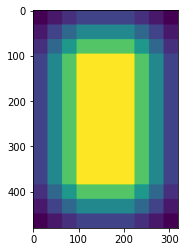

In [ ]:
plt.imshow(voting_mask)

In [ ]:
results = []
for m in range(12):
    pred = np.zeros((x_train.shape[-3], x_train.shape[-2]))
    k = 0
    for i in range((x_train.shape[3]-feature_size)//stride+1):
        for j in range((x_train.shape[4]-feature_size)//stride+1):
            pred[stride*i:stride*i+feature_size, stride*j:stride*j+feature_size] += preds[m][k,-1,:,:,0]
            k+=1
    pred /= voting_mask
    results.append(pred[:448, :304])
results = np.array(results)

# 추론 결과

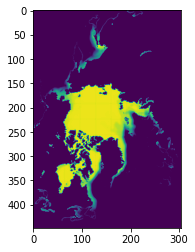

1 



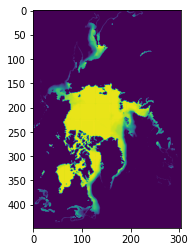

2 



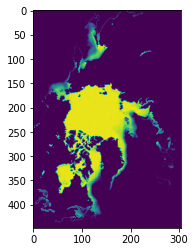

3 



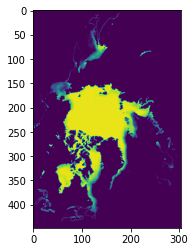

4 



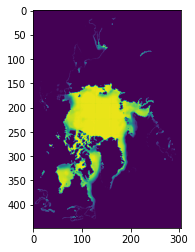

5 



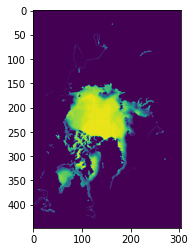

6 



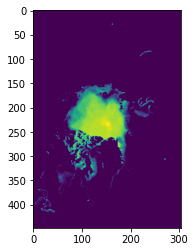

7 



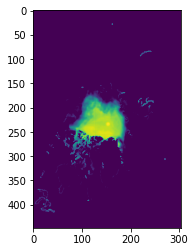

8 



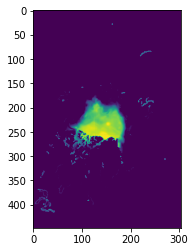

9 



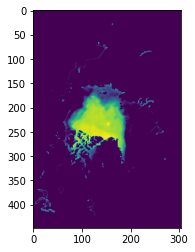

10 



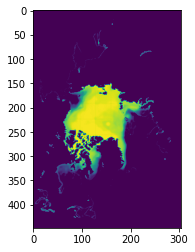

11 



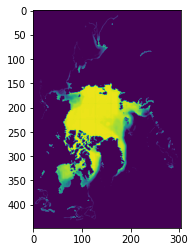

12 



In [ ]:
for m in range(12):
    plt.imshow(results[m])
    plt.show()
    print(m+1, '\n')

# 제출

In [ ]:
submission = pd.read_csv(path+'sample_submission.csv')
submission

,month,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,136152,136153,136154,136155,136156,136157,136158,136159,136160,136161,136162,136163,136164,136165,136166,136167,136168,136169,136170,136171,136172,136173,136174,136175,136176,136177,136178,136179,136180,136181,136182,136183,136184,136185,136186,136187,136188,136189,136190,136191
0,2019-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2019-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2019-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2019-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2019-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2019-06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,2019-07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,2019-08,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,2019-09,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,2019-10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


submission의 값을 변경할 경우 시간이 오래걸려 추론 결과를 reshape하여 붙였습니다.

In [ ]:
sub_2019 = submission.loc[:11, ['month']].copy()
sub_2020 = submission.loc[12:].copy()

sub_2019 = pd.concat([sub_2019, (pd.DataFrame(results.reshape([12,-1])))], axis=1)
sub_2019.columns = submission.columns
submission = pd.concat([sub_2019, sub_2020])

In [ ]:
submission

,month,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,136152,136153,136154,136155,136156,136157,136158,136159,136160,136161,136162,136163,136164,136165,136166,136167,136168,136169,136170,136171,136172,136173,136174,136175,136176,136177,136178,136179,136180,136181,136182,136183,136184,136185,136186,136187,136188,136189,136190,136191
0,2019-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.230574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.230574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.230574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.230574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.230574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2019-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.230574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2019-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.230574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2019-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.230574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2019-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.230574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2019-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.230574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


결과 저장

In [ ]:
submission.to_csv('submission.csv', index=False)